In [1]:
import sys
sys.path.append('..') #to add top-level to path

from modules.opts import VolCurveAgg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle


## Introduction

For the terminology and concepts used in this section, please look at the Market Theory section.

Exhanges make public how many contracts are currently outstanding in futures and options trading at any one time. This is known as the open interest.

Option sellers that hedge their position with the underlying lose money when the asset moves. This is caused by the convexity of the options price with respect to the underlying. The convexity is measured by the gamma. The gamma is the rate of change of delta,  or how much the options price moves with respect to the underlying. The delta increases (in absolute terms) as an option moves into the money. 

The (absolute value) of a delta ranges from 0 to 1. A delta of 0 can be interpreted as the market pricing extremely low chances of the option being profitable for the buyer. A delta of 1 can be thought of as pricing the option having extremely low chances of not being profitable for the buyer, and so behaves exactly like the underlying.

This means that, on large, unexpected moves, the deltas of out-of-the-money options increase in a dramatic way, and options sellers need to hedge their position by trading in the direction of the large move. 

Since we know the open interest outstanding for options at any time, we can calculate how much this delta would increase given a move in the underlying! This is what we call the aggregate gamma. Higher open interest and a large unexpected move can trigger even larger moves as options sellers need to hedge their positions. 

## Gamma features

After scraping, we obtain the features in the gamma_features notebook. The features are calculated as follows. For every day, for every asset, through the VolCurveAgg() class in the opts.py module:

- Obtain the futures price for each expiration, either from the dictionary itself, or if not provided by the settlement file, through the FuturesCurve() class, which interpolates futures prices inside 2 months of expiration. If we don't have the futures price and it's outside of 2 months, discard the expiration.
- Obtain the interest rate for each expiration through the RatesCurve() class, which interpolates 1 month, 3 month, and 6 month LIBOR. 
- Find the strikes which have lie between 80% and 120% moneyness for the futures contract for that date i.e., 0.8 * futures <= strike <= 1.2*futures
- Obtain the implied volatility for each strike in this range through Newton's method. 
- Calculate the gamma for each out of the money strike, both above  102.5% moneyness and below 97.5% moneyness, i.e, strike >= 1.025 * futures | strike <= 0.975 * futures
- Calculate the gamma for the same strikes but assuming the futures contract had a 5% up (down) move. 
- Multiply these gammas by the open interest for each strike.
- up_gamma: Add the gammas of strikes above the futures price across different expirations
- down_gamma: Add the gammas of strikes below the futures price across different expirations
- up_gamma_5: Add the gammas of strikes above the futures price across different expirations, assuming a 5% move up
- down_gamma_5: Add the gammas of strikes below the futures price across different expirations, assuming a 5% move down
- up_gamma_diff = up_gamma_5 - up_gamma:  Increase in gamma on the +5% move. This number should always be positive
- down_gamma_diff = down_gamma - down_gamma_5: Increase in gamma on the -5% move. This number should always be positive

In [2]:
with open('../data/intermediate_data/corn_dict.pickle','rb') as f:
    corn_dict = pickle.load(f)
with open('../data/intermediate_data//wheat_dict.pickle','rb') as f:
    wheat_dict = pickle.load(f)
with open('../data/intermediate_data//soybeans_dict.pickle','rb') as f:
    soybeans_dict = pickle.load(f)


In [3]:
corn_gamma_features = pd.DataFrame(index = corn_dict.keys(), columns = ['C_up_gamma', 
                                                                        'C_up_gamma_5', 
                                                                        'C_down_gamma',
                                                                        'C_down_gamma_5'])
for key in tqdm(corn_dict.keys()):
    vc = VolCurveAgg('C', key, corn_dict)
    corn_gamma_features.loc[key] = vc.features.iloc[0]

corn_gamma_features['C_up_diff_5'] = corn_gamma_features['C_up_gamma_5'] - corn_gamma_features['C_up_gamma']
corn_gamma_features['C_down_diff_5'] = corn_gamma_features['C_down_gamma_5'] - corn_gamma_features['C_down_gamma']

100%|██████████| 457/457 [02:03<00:00,  3.69it/s]


In [4]:
wheat_gamma_features = pd.DataFrame(index = wheat_dict.keys(), columns = ['W_up_gamma', 
                                                                          'W_up_gamma_5', 
                                                                          'W_down_gamma',
                                                                          'W_down_gamma_5'])
for key in tqdm(wheat_dict.keys()):
    vc = VolCurveAgg('W', key, wheat_dict)
    wheat_gamma_features.loc[key] = vc.features.iloc[0]
    
wheat_gamma_features['W_up_diff_5'] = wheat_gamma_features['W_up_gamma_5'] - wheat_gamma_features['W_up_gamma']
wheat_gamma_features['W_down_diff_5'] = wheat_gamma_features['W_down_gamma_5'] - wheat_gamma_features['W_down_gamma']

100%|██████████| 422/422 [01:52<00:00,  3.76it/s]


In [5]:
soybeans_gamma_features = pd.DataFrame(index = soybeans_dict.keys(), columns = ['S_up_gamma', 
                                                                                'S_up_gamma_5', 
                                                                                'S_down_gamma',
                                                                                'S_down_gamma_5'])
for key in tqdm(soybeans_dict.keys()):
    vc = VolCurveAgg('S', key, soybeans_dict)
    soybeans_gamma_features.loc[key] = vc.features.iloc[0]
    
soybeans_gamma_features['S_up_diff_5'] = soybeans_gamma_features['S_up_gamma_5'] - soybeans_gamma_features['S_up_gamma']
soybeans_gamma_features['S_down_diff_5'] = soybeans_gamma_features['S_down_gamma_5'] - soybeans_gamma_features['S_down_gamma']

100%|██████████| 438/438 [02:19<00:00,  3.14it/s]


In [6]:
corn_feat_cols = ['C_up_gamma_5','C_down_gamma_5', 'C_up_diff_5','C_down_diff_5']
corn_gamma_features.index.name = 'date'
corn_gamma_features[corn_feat_cols].to_csv('../data/features/corn_gamma_features.csv')
corn_gamma_features.head()

,C_up_gamma,C_up_gamma_5,C_down_gamma,C_down_gamma_5,C_up_diff_5,C_down_diff_5
date,,,,,,
2016-09-21,41950.8,53219.4,41912.9,53384.3,11268.6,11471.4
2016-09-22,41142.9,52737.6,42436.2,54080.6,11594.6,11644.4
2016-09-27,43065.8,56031.6,30289.5,37727.2,12965.8,7437.72
2016-09-29,43909.4,56912.6,31192,39498.5,13003.2,8306.5
2016-09-30,43952.3,56946.5,31746.4,40410.8,12994.2,8664.38


https://quant.stackexchange.com/questions/32974/proof-of-gamma-profit-formula

/Users/lalopey/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


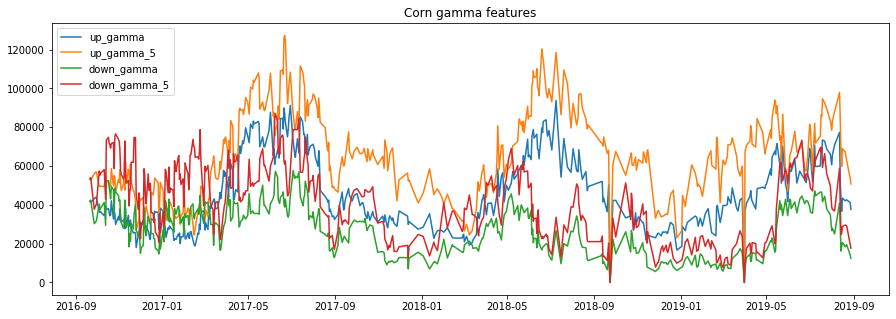

In [7]:
plt.subplots(figsize=(15,5))
plt.plot(corn_gamma_features['C_up_gamma'], label = 'up_gamma')
plt.plot(corn_gamma_features['C_up_gamma_5'], label = 'up_gamma_5')
         
plt.plot(corn_gamma_features['C_down_gamma'], label = 'down_gamma')
plt.plot(corn_gamma_features['C_down_gamma_5'], label = 'down_gamma_5')

plt.title("Corn gamma features")
plt.legend();

- Up_gamma_5 should always be larger than up_gamma, and down_gamma_5 should always be larger than down_gamma. As we move up (down) in spot, the delta of out of the money options increases at a faster rate, and so the potential options sellers to hedge their short options positions by buying (selling) more into the move.

- Notice those big spikes down around the end of 2018 and around april 2019. These were big moves in the spot over the weekend. For example, the one in April was caused by very heavy rains all across the MidWest that were threatening planting of agricultural products, and thus drove prices up across the board. The dataset we have has the open interest of the previous day, so when we calculate the gamma with a much higher spot price, we don't see all the new upside option buying in the open interest available to us. These spikes down are "realizations" of big gamma moves.

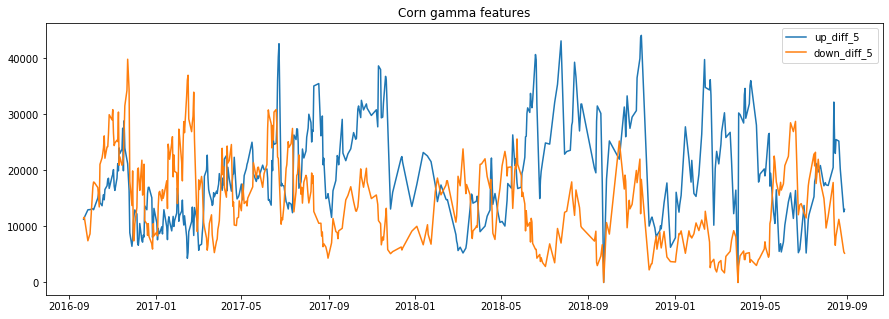

In [8]:
plt.subplots(figsize=(15,5))
plt.plot(corn_gamma_features['C_up_diff_5'], label = 'up_diff_5')
plt.plot(corn_gamma_features['C_down_diff_5'], label = 'down_diff_5')
plt.title("Corn gamma features")
plt.legend();

In [15]:
wheat_feat_cols = ['W_up_gamma_5','W_down_gamma_5', 'W_up_diff_5','W_down_diff_5']
wheat_gamma_features.index.name = 'date'
wheat_gamma_features[wheat_feat_cols].to_csv('../data/features/wheat_gamma_features.csv')
wheat_gamma_features.head()

,W_up_gamma,W_up_gamma_5,W_down_gamma,W_down_gamma_5,W_up_diff_5,W_down_diff_5
date,,,,,,
2016-09-27,8576.26,11281.7,4087.66,5119.84,2705.44,1032.19
2016-09-29,8748.94,11350.2,4969.16,6931.76,2601.23,1962.6
2016-10-04,8552.08,11246,4946.62,6619.58,2693.88,1672.96
2016-10-11,11749.6,14704.7,6785.7,9338.08,2955.02,2552.38
2016-10-13,14455.3,18394,5898.95,8111.15,3938.7,2212.2


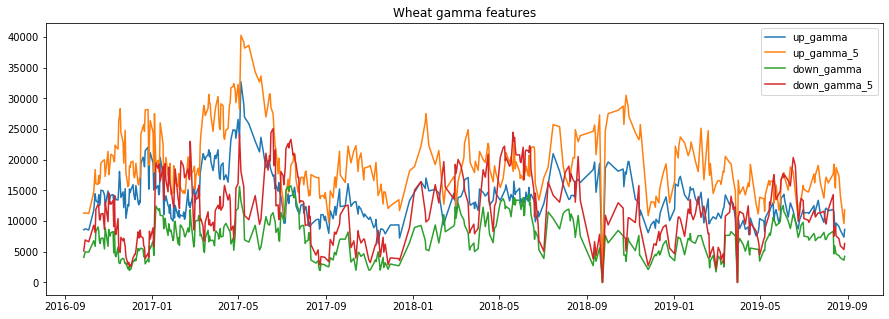

In [10]:
plt.subplots(figsize=(15,5))
plt.plot(wheat_gamma_features['W_up_gamma'], label = 'up_gamma')
plt.plot(wheat_gamma_features['W_up_gamma_5'], label = 'up_gamma_5')
         
plt.plot(wheat_gamma_features['W_down_gamma'], label = 'down_gamma')
plt.plot(wheat_gamma_features['W_down_gamma_5'], label = 'down_gamma_5')

plt.title("Wheat gamma features")
plt.legend();

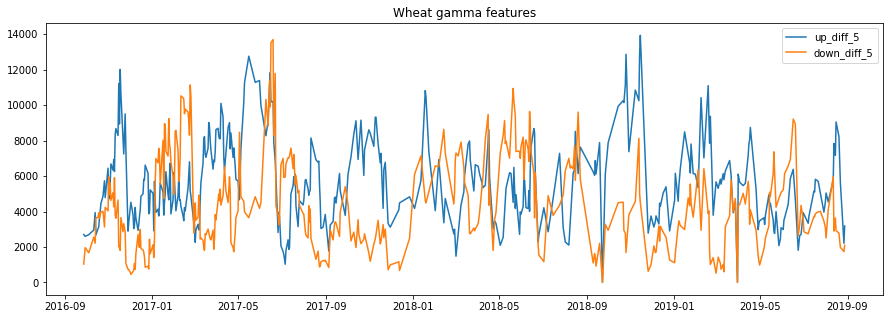

In [11]:
plt.subplots(figsize=(15,5))
plt.plot(wheat_gamma_features['W_up_diff_5'], label = 'up_diff_5')
plt.plot(wheat_gamma_features['W_down_diff_5'], label = 'down_diff_5')
plt.title("Wheat gamma features")
plt.legend();

In [16]:
soybeans_feat_cols = ['S_up_gamma_5','S_down_gamma_5', 'S_up_diff_5','S_down_diff_5']
soybeans_gamma_features.index.name = 'date'
soybeans_gamma_features[soybeans_feat_cols].to_csv('../data/features/soybeans_gamma_features.csv')
soybeans_gamma_features.head()

,S_up_gamma,S_up_gamma_5,S_down_gamma,S_down_gamma_5,S_up_diff_5,S_down_diff_5
date,,,,,,
2016-09-21,21281.9,34465.7,22955.4,39120.5,13183.8,16165.1
2016-09-22,24363.4,37548.5,23053.6,38822.6,13185.1,15769.1
2016-09-23,16074.6,29833.2,22494.6,39086.8,13758.6,16592.2
2016-09-26,23479,39720.8,19206.1,33082.3,16241.8,13876.2
2016-09-27,22043.8,38721.8,21561.6,34020.3,16678,12458.7


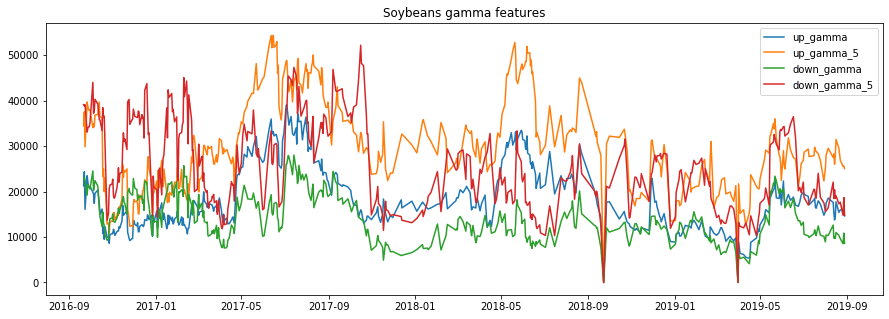

In [13]:
plt.subplots(figsize=(15,5))
plt.plot(soybeans_gamma_features['S_up_gamma'], label = 'up_gamma')
plt.plot(soybeans_gamma_features['S_up_gamma_5'], label = 'up_gamma_5')
         
plt.plot(soybeans_gamma_features['S_down_gamma'], label = 'down_gamma')
plt.plot(soybeans_gamma_features['S_down_gamma_5'], label = 'down_gamma_5')

plt.title("Soybeans gamma features")
plt.legend();

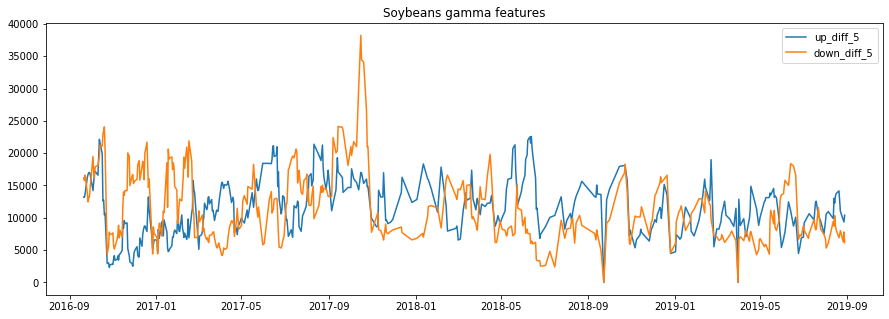

In [14]:
plt.subplots(figsize=(15,5))
plt.plot(soybeans_gamma_features['S_up_diff_5'], label = 'up_diff_5')
plt.plot(soybeans_gamma_features['S_down_diff_5'], label = 'down_diff_5')
plt.title("Soybeans gamma features")
plt.legend();